In [25]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from neighborhoods import nearest_neighborhood
from datetime import date
from dateutil.relativedelta import relativedelta

In [26]:
df = pd.read_csv('eviction_notices.csv', parse_dates=['File Date'], encoding = "ISO-8859-1")

/Users/jakram/anaconda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [27]:
len(df)

37736

In [28]:
df.head()

,Eviction ID,Address,City,State,Eviction Notice Source Zipcode,File Date,Non Payment,Breach,Nuisance,Illegal Use,...,Roommate Same Unit,Other Cause,Late Payments,Lead Remediation,Development,Good Samaritan Ends,Constraints Date,Supervisor District,Neighborhoods - Analysis Boundaries,Location
0,M161957,300 Block Of Park Street,San Francisco,CA,94110,2016-06-06,False,False,False,False,...,False,False,False,False,False,False,NaN,9.0,Bernal Heights,"(37.7364374645373, -122.417989910582)"
1,M162256,200 Block Of Seneca Avenue,San Francisco,CA,94112,2016-06-29,False,False,False,False,...,False,False,False,False,False,False,8/25/2021,11.0,Outer Mission,"(37.7205429316262, -122.443264852669)"
2,M162135,200 Block Of Dolores Street,San Francisco,CA,94103,2016-06-28,False,True,False,False,...,False,False,False,False,False,False,NaN,8.0,Castro/Upper Market,"(37.7652067507312, -122.426591617441)"
3,M161901,1200 Block Of 9th Avenue,San Francisco,CA,94122,2016-06-02,False,False,False,False,...,False,False,False,False,False,False,NaN,5.0,Inner Sunset,"(37.764977785911, -122.4664456379)"
4,M162428,1400 Block Of Larkin Street,San Francisco,CA,94109,2016-02-28,False,False,False,False,...,False,False,False,False,False,False,NaN,3.0,Nob Hill,"(37.7912373166567, -122.419197310472)"


In [29]:
# Dump all rows with no file date (eviction date) or location data (lat, lng).
df = df.dropna(subset=['Location','File Date'])
len(df)

36289

In [30]:
mindate = date(2007, 9, 1) # This is the minimum date for which we have home values from Zillow.
maxdate = date(2017, 7, 1)

# This is the number of lookback months to find change in home values prior to an eviction.
lookbackperiod_mos = 36 

# Start date: the date after which evicitons are included in the analysis.
startdatetime = mindate + relativedelta(months=+lookbackperiod_mos)

# End date: the maximum eviciton date that will be included in the analysis. 
enddatetime = maxdate

# Trimming the dataset to remove very early values that would not return values in the lookback period.
df = df[df['File Date'] >= startdatetime]
df = df[df['File Date'] <= enddatetime]

len(df)

12027

In [31]:
startdate = date.strftime(startdatetime,"%b %Y")
startdate

'Sep 2010'

In [32]:
enddate = date.strftime(enddatetime, "%b %Y")
enddate

'Jul 2017'

In [33]:
# These are the column names for evictions that are non-cause:
for_cause_eviction_names = ['Non Payment',
                            'Breach',
                            'Nuisance',
                            'Illegal Use',
                            'Failure to Sign Renewal',
                            'Access Denial',
                            'Unapproved Subtenant',
                            'Roommate Same Unit',
                            'Other Cause',
                            'Late Payments',
                            'Lead Remediation',
                            'Good Samaritan Ends']

non_cause_eviction_names = ['Owner Move In',
                            'Condo Conversion',
                            'Ellis Act WithDrawal',
                            'Substantial Rehab',
                            'Development',
                            'Demolition',
                            'Capital Improvement',
                            'Substantial Rehab'
                           ]

In [34]:
def addEvicitonType(row):
    countnoncause = row[non_cause_eviction_names].sum(axis=0)
    countcause = row[for_cause_eviction_names].sum(axis=0)
    if (countnoncause + countcause) == 0:
        group = 'Non-Cause'
    elif countnoncause >= 1:
        group = 'Non-Cause'
    else:
        group = 'Cause'
    return pd.Series({'count_non_cause': countnoncause, 'count_cause': countcause, 'group': group})

df = df.merge(df.apply(addEvicitonType, axis=1), left_index=True, right_index=True)
df.head()

,Eviction ID,Address,City,State,Eviction Notice Source Zipcode,File Date,Non Payment,Breach,Nuisance,Illegal Use,...,Lead Remediation,Development,Good Samaritan Ends,Constraints Date,Supervisor District,Neighborhoods - Analysis Boundaries,Location,count_cause,count_non_cause,group
0,M161957,300 Block Of Park Street,San Francisco,CA,94110,2016-06-06,False,False,False,False,...,False,False,False,NaN,9.0,Bernal Heights,"(37.7364374645373, -122.417989910582)",0,1,Non-Cause
1,M162256,200 Block Of Seneca Avenue,San Francisco,CA,94112,2016-06-29,False,False,False,False,...,False,False,False,8/25/2021,11.0,Outer Mission,"(37.7205429316262, -122.443264852669)",0,1,Non-Cause
2,M162135,200 Block Of Dolores Street,San Francisco,CA,94103,2016-06-28,False,True,False,False,...,False,False,False,NaN,8.0,Castro/Upper Market,"(37.7652067507312, -122.426591617441)",1,0,Cause
3,M161901,1200 Block Of 9th Avenue,San Francisco,CA,94122,2016-06-02,False,False,False,False,...,False,False,False,NaN,5.0,Inner Sunset,"(37.764977785911, -122.4664456379)",0,1,Non-Cause
4,M162428,1400 Block Of Larkin Street,San Francisco,CA,94109,2016-02-28,False,False,False,False,...,False,False,False,NaN,3.0,Nob Hill,"(37.7912373166567, -122.419197310472)",0,1,Non-Cause


In [35]:
# Function appends data from Zillow API and data file using neighborhood()  
def addPricingData_lookback(row, lookback):
    latlng = row['Location']
    lat, lng = latlng.split(',')
    lat = float(lat.replace('(','')) # Reformat lat, lng to separate arguments.
    lng = float(lng.replace(')',''))
    evictdate = row['File Date'].date() # Convert eviction date and create date keys for eviciton date and starting valuation date. 
    startdate = evictdate + relativedelta(months=-lookback)
    evictdate_key = date.strftime(evictdate,"%b%Y")
    evictdateyear = date.strftime(evictdate,"%Y")
    startdate_key = date.strftime(startdate, "%b%Y")
    neighborhood = nearest_neighborhood(lat, lng) # Create neighborhood object for lat, lng.
    name = neighborhood.name
    meanvalue = float(neighborhood.meanvalue)
    evictdatevalue = neighborhood.prices[evictdate_key]
    s = neighborhood.prices[startdate_key]
    c = neighborhood.prices[evictdate_key]
    valueincrease = (c - s)/s
    return pd.Series({'Eviction_id':row['Eviction ID'],'Lat': lat, 'Lng': lng, 'Year': evictdateyear, 'Zillow_Neighborhood':name, 'Z_2017_Value':meanvalue, 'Z_Evict_Date_Value':evictdatevalue, 'Z_Value_Increase':valueincrease}) 
    

In [36]:
# This dictionary can be used to count each type of eviciton during an aggregation.
baseaggregation = {
#     'Owner Move In' : {
#         'total_move_in' : 'sum'
#     },
#     'Condo Conversion' : {
#          'total_condo' : 'sum'
#     },
#     'Ellis Act WithDrawal' : {
#          'total_ellis' : 'sum'
#     },
#     'Development' : {
#          'total_development' : 'sum'
#     },
#     'Demolition' : {
#          'total_demolition' : 'sum'
#     },
#     'Capital Improvement' : {
#          'total_capital_improvement' : 'sum'
#     },
#     'Substantial Rehab' : {
#          'total_substantial_rehab' : 'sum'
#     },
#     'Non Payment' : {
#          'total_non_payment' : 'sum'
#     },
#     'Breach' : {
#          'total_breach' : 'sum'
#     },
#     'Nuisance' : {
#          'total_nuisance' : 'sum'
#     },
#     'Illegal Use' : {
#          'total_illegal_use' : 'sum'
#     },
#     'Failure to Sign Renewal' : {
#          'total_non_renewal' : 'sum'
#     },
#     'Access Denial' : {
#          'total_access_denial' : 'sum'
#     },
#     'Unapproved Subtenant' : {
#          'total_unapproved_subtenant' : 'sum'
#     },
#     'Roommate Same Unit' : {
#          'total_roommate' : 'sum'
#     },
#     'Other Cause' : {
#          'total_other_cause' : 'sum'
#     },
#     'Late Payments' : {
#          'total_late_payment' : 'sum'
#     },
#     'Good Samaritan Ends' : {
#          'total_total_good_samaritan' : 'sum'
#     },
    'Eviction ID' : {
        'total_evictions' : 'count'
    },
    'Z_2017_Value' : {
        'current_value' : 'mean'
    },
    'Z_Evict_Date_Value' :{ 
        'eviction_date_value' : 'mean'
    },
    'count_cause' : {
        'cause_evictions' : 'sum'
    },
    'count_non_cause' : {
        'non_cause_evictions' : 'sum'
    },
}

In [37]:
# Merge the results of our calls to neighborhood() back to our dataframe.
allevictions = df.merge(df.apply(lambda row: addPricingData_lookback(row, lookbackperiod_mos), axis = 1), left_index=True, right_index=True)
allevictions.head()

,Eviction ID,Address,City,State,Eviction Notice Source Zipcode,File Date,Non Payment,Breach,Nuisance,Illegal Use,...,count_non_cause,group,Eviction_id,Lat,Lng,Year,Z_2017_Value,Z_Evict_Date_Value,Z_Value_Increase,Zillow_Neighborhood
0,M161957,300 Block Of Park Street,San Francisco,CA,94110,2016-06-06,False,False,False,False,...,1,Non-Cause,M161957,37.736437,-122.417990,2016,1083700.0,1193000.0,0.404025,Bernal Heights
1,M162256,200 Block Of Seneca Avenue,San Francisco,CA,94112,2016-06-29,False,False,False,False,...,1,Non-Cause,M162256,37.720543,-122.443265,2016,814200.0,951300.0,0.341371,Mission Terrace
2,M162135,200 Block Of Dolores Street,San Francisco,CA,94103,2016-06-28,False,True,False,False,...,0,Cause,M162135,37.765207,-122.426592,2016,0.0,NaN,NaN,Duboce Triangle
3,M161901,1200 Block Of 9th Avenue,San Francisco,CA,94122,2016-06-02,False,False,False,False,...,1,Non-Cause,M161901,37.764978,-122.466446,2016,1154400.0,1362400.0,0.446899,Inner Sunset
4,M162428,1400 Block Of Larkin Street,San Francisco,CA,94109,2016-02-28,False,False,False,False,...,1,Non-Cause,M162428,37.791237,-122.419197,2016,1192900.0,1461900.0,0.434079,Nob Hill


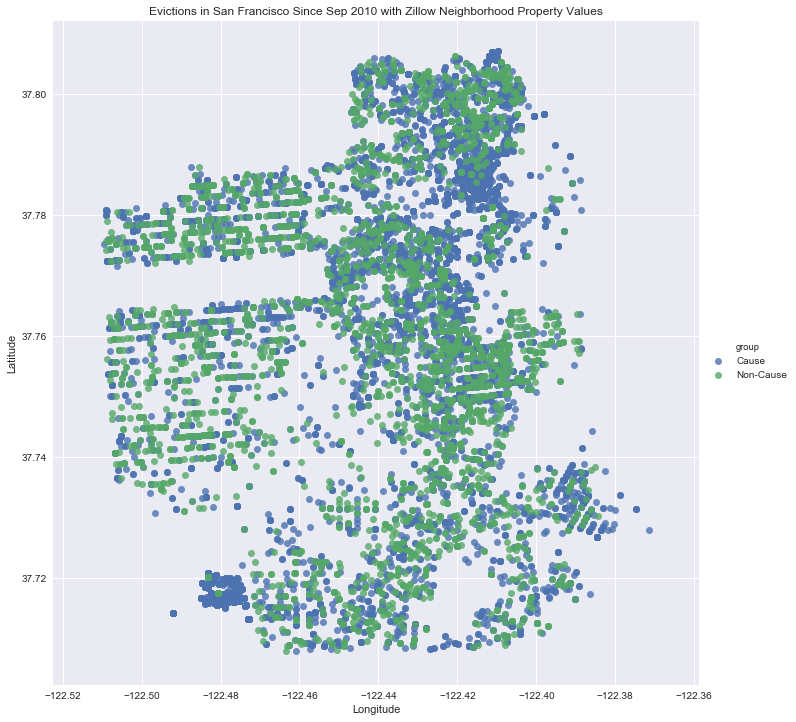

In [62]:
ax = sns.lmplot(x='Lng', y='Lat', hue='group', hue_order=['Cause', 'Non-Cause'],  size=10, data=allevictions, fit_reg=False)
ax.despine(left=True)

# Set title, x-axis label, y-axis label.
plt.title('Evictions in San Francisco Since %s with Zillow Neighborhood Property Values' % startdate)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.savefig('Images/evictions_map.png')
plt.show()

In [40]:
# Adding a key value pair for the zillow value increase for our lookback function. 
aggregation_lookback = dict(baseaggregation)
aggregation_lookback.update({ 'Z_Value_Increase' : {'average_value_increase' : 'mean'},})

# Creating a dataframe to group by neighborhood. 
groupby_hood = allevictions.groupby([('Zillow_Neighborhood')],as_index=True).agg(aggregation_lookback).reset_index()

groupby_hood.columns = groupby_hood.columns.droplevel(level=1)


# Creating a row-wise sum of all the non-cause eviciton counts.
# groupby_hood['total_non_cause'] = groupby_hood[non_cause_eviction_names].sum(axis=1)

# Adding a column to show the frequency of non-cause evicitons.
groupby_hood['non_cause_frequency'] = (groupby_hood['count_non_cause']/
                                                               groupby_hood['Eviction ID']
                                                              )

# Drop rows for neighborhoods without pricing data.
groupby_hood_pricing = groupby_hood.dropna(subset=['Z_Value_Increase']).reset_index()



# Drop neighborhoods with small sample sizes.
plot_non_cause_frequency = groupby_hood_pricing[groupby_hood_pricing['Eviction ID'] > 30]

plot_non_cause_frequency.head()


,index,Zillow_Neighborhood,Eviction ID,Z_2017_Value,Z_Evict_Date_Value,count_cause,count_non_cause,Z_Value_Increase,non_cause_frequency
0,3,Bayview,253,612400.0,6.249269e+05,232,40,0.603670,0.158103
1,4,Bernal Heights,406,1083700.0,1.002694e+06,224,203,0.309051,0.500000
2,5,Buena Vista Park,106,1304100.0,1.163381e+06,60,36,0.203253,0.339623
3,6,Central Richmond,248,1284800.0,1.206298e+06,171,101,0.366586,0.407258
4,7,Central Sunset,200,994300.0,9.888375e+05,96,106,0.276878,0.530000


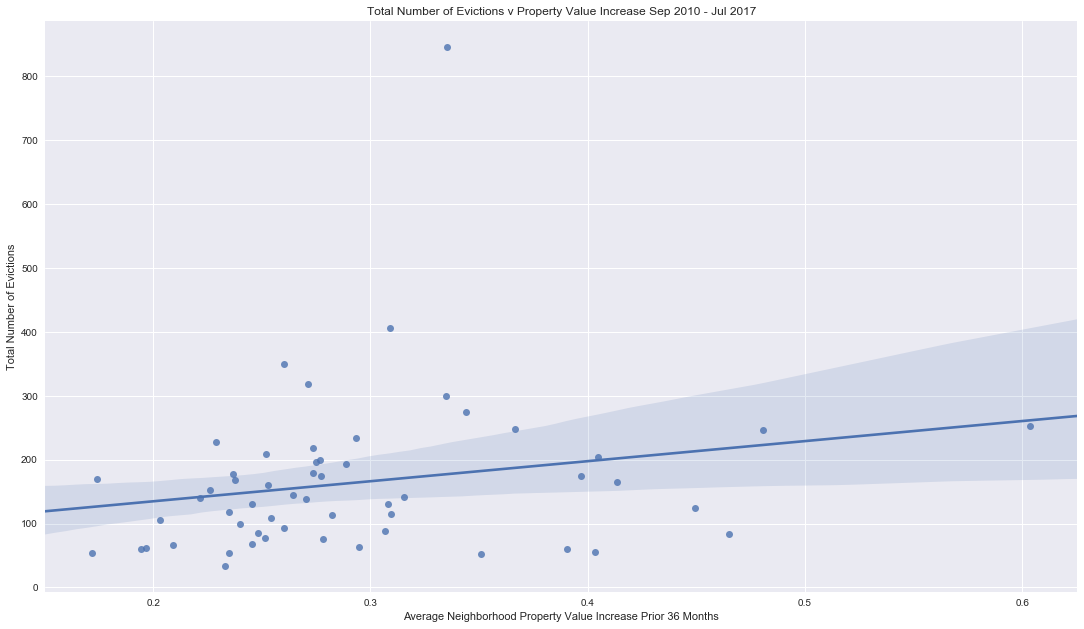

In [41]:
fig, ax = plt.subplots()
fig.set_size_inches(18.5, 10.5)
ax = sns.regplot(y='Eviction ID', x='Z_Value_Increase', data=plot_non_cause_frequency)
plt.title('Total Number of Evictions v Property Value Increase %s - %s' % (startdate, enddate))
plt.ylabel('Total Number of Evictions')
plt.xlabel('Average Neighborhood Property Value Increase Prior %s Months' % lookbackperiod_mos)
plt.savefig('Images/evictions_total_v_homevalues.png')
plt.show()

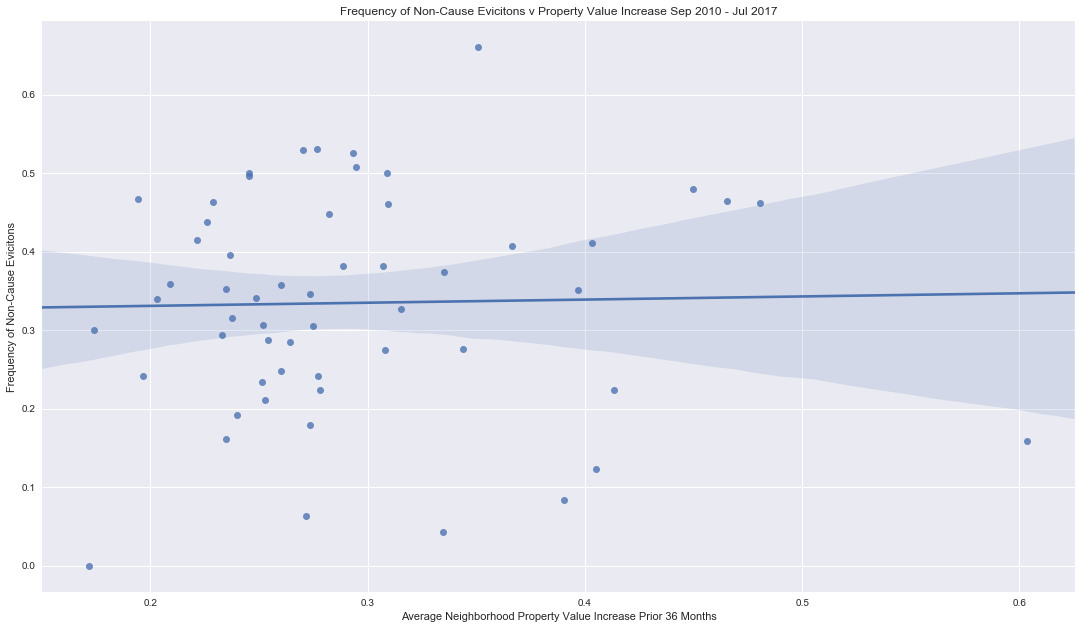

In [42]:
fig, ax = plt.subplots()
fig.set_size_inches(18.5, 10.5)
ax = sns.regplot(y='non_cause_frequency', x='Z_Value_Increase', data=plot_non_cause_frequency)
plt.title('Frequency of Non-Cause Evicitons v Property Value Increase %s - %s' % (startdate, enddate))
plt.ylabel('Frequency of Non-Cause Evicitons')
plt.xlabel('Average Neighborhood Property Value Increase Prior %s Months' % lookbackperiod_mos)
plt.savefig('Images/evictions_freq_v_homevalues.png')
plt.show()

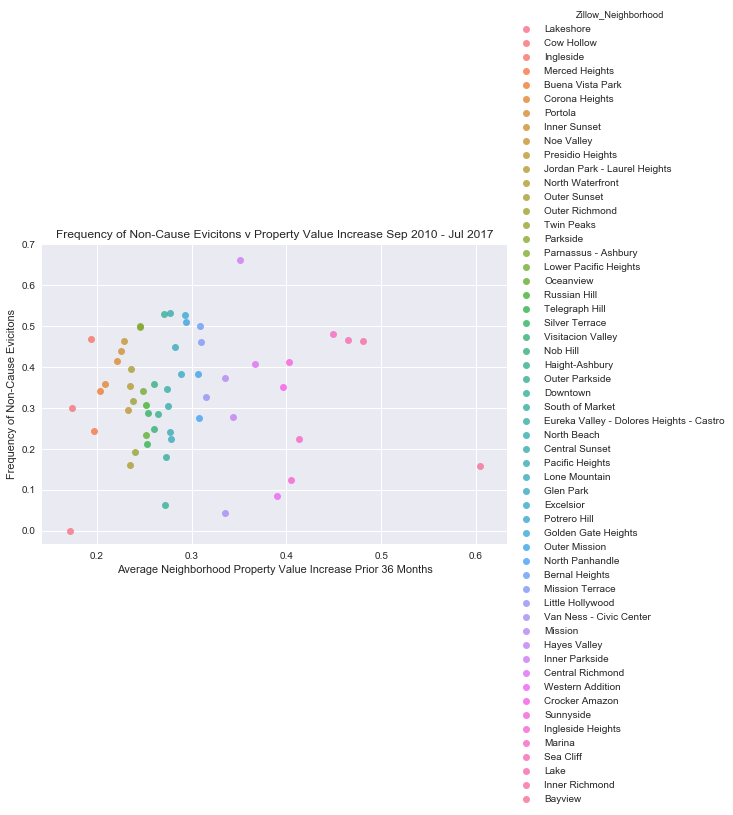

In [43]:
lmplot_non_cause_frequency = plot_non_cause_frequency.sort_values(by=('Z_Value_Increase'))

# Set style of scatterplot
sns.set(style="darkgrid")

# Create scatterplot of non-cause eviciton frequency with property value increase.
ax = sns.lmplot('Z_Value_Increase', # Horizontal axis
                'non_cause_frequency', # Vertical axis
                data = lmplot_non_cause_frequency, # Data source
                fit_reg = False, # Don't fix a regression line
                hue = 'Zillow_Neighborhood', # Set color
#                 markers = markers
                aspect=1.5
          )

# Set title, x-axis label, y-axis label.
plt.title('Frequency of Non-Cause Evicitons v Property Value Increase %s - %s' % (startdate, enddate))
plt.ylabel('Frequency of Non-Cause Evicitons')
plt.xlabel('Average Neighborhood Property Value Increase Prior %s Months' % lookbackperiod_mos)
plt.savefig('Images/evictions_freq_v_homevalues_hue.png')
plt.show()

In [44]:
groupby_hood.head()

,Zillow_Neighborhood,Eviction ID,Z_2017_Value,Z_Evict_Date_Value,count_cause,count_non_cause,Z_Value_Increase,non_cause_frequency
0,Alamo Square,154,0.0,NaN,119,42,NaN,0.272727
1,Anza Vista,142,0.0,NaN,94,55,NaN,0.387324
2,Balboa Terrace,6,0.0,NaN,6,0,NaN,0.000000
3,Bayview,253,612400.0,6.249269e+05,232,40,0.603670,0.158103
4,Bernal Heights,406,1083700.0,1.002694e+06,224,203,0.309051,0.500000


In [45]:
def kind(row):
   if row['index'] in non_cause_eviction_names:
      return 'Non-Cause'
   else:
      return 'Cause'

evictions_types = df[for_cause_eviction_names + non_cause_eviction_names]
evictions_types = evictions_types.transpose().reset_index()
evictions_types['Total'] = evictions_types.sum(axis=1)
evictions_types['Category'] = evictions_types.apply (lambda row: kind(row),axis=1)


evictions_types

,index,0,1,2,3,4,5,6,7,8,...,37728,37729,37730,37731,37732,37733,37734,37735,Total,Category
0,Non Payment,False,False,False,False,False,False,False,True,False,...,False,False,False,False,True,False,False,False,703,Cause
1,Breach,False,False,True,False,False,False,True,False,False,...,False,True,False,True,False,False,False,False,3638,Cause
2,Nuisance,False,False,False,False,False,True,False,False,False,...,False,False,False,False,False,False,False,False,2247,Cause
3,Illegal Use,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,406,Cause
4,Failure to Sign Renewal,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,37,Cause
5,Access Denial,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,117,Cause
6,Unapproved Subtenant,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,143,Cause
7,Roommate Same Unit,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,310,Cause
8,Other Cause,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,327,Cause
9,Late Payments,False,False,False,False,False,False,False,False,False,...,False,False,True,False,True,False,True,False,511,Cause


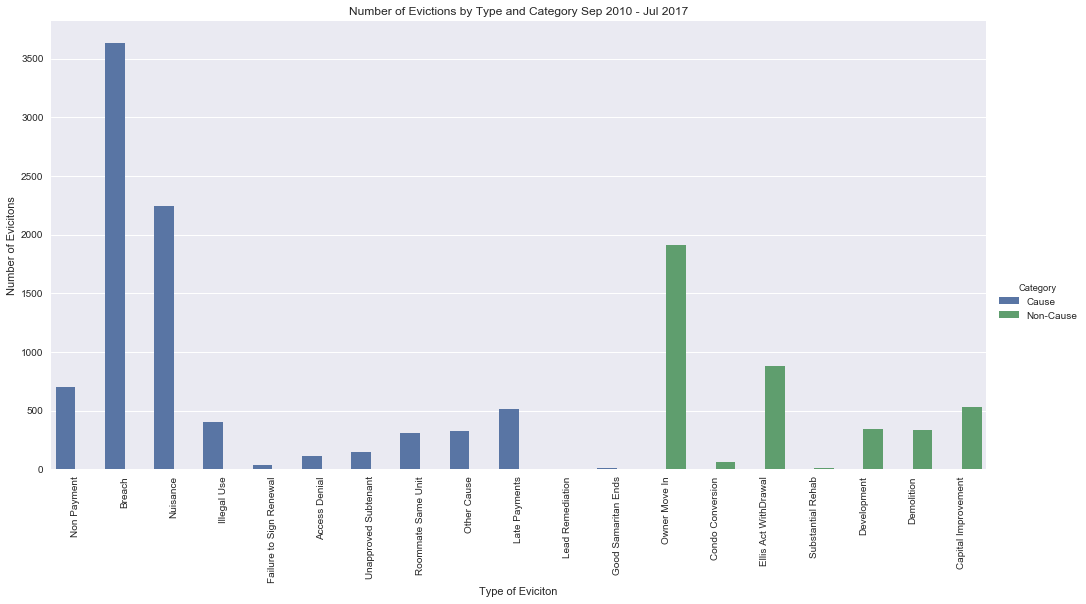

In [63]:
axa = sns.factorplot(x='index', y='Total', hue='Category', data=evictions_types, hue_order=['Cause', 'Non-Cause'], kind='bar', size=7, aspect=2)
axa.set_xticklabels(rotation=90)
plt.title('Number of Evictions by Type and Category %s - %s' % (startdate, enddate))
plt.ylabel('Number of Evicitons')
plt.xlabel('Type of Eviciton')
plt.savefig('Images/evictions_by_category.png')
plt.show()

In [58]:
# Creating a dataframe to group by year, then neighborhood. 
groupby_month = allevictions
groupby_month['datetime'] = pd.to_datetime(groupby_month['File Date'])
groupby_month.index = groupby_month['datetime']

groupby_month = groupby_month.resample('M').agg(baseaggregation)
groupby_month.columns = groupby_month.columns.droplevel(level=1)

# groupby_month['total_non_cause'] = groupby_month[non_cause_eviction_names].sum(axis=1)
groupby_month

,Eviction ID,Z_2017_Value,Z_Evict_Date_Value,count_cause,count_non_cause
datetime,,,,,
2010-09-30,188,4.371080e+05,8.447338e+05,64,122
2010-10-31,120,7.843950e+05,7.721928e+05,108,14
2010-11-30,96,1.003168e+06,8.124325e+05,75,14
2010-12-31,45,8.597333e+05,7.716794e+05,41,7
2011-01-31,77,9.253883e+05,7.266508e+05,69,11
2011-02-28,94,1.030012e+06,7.724651e+05,69,29
2011-03-31,102,9.375598e+05,7.394716e+05,88,18
2011-04-30,59,1.055266e+06,7.510278e+05,50,14
2011-05-31,130,5.998731e+05,6.845338e+05,108,27


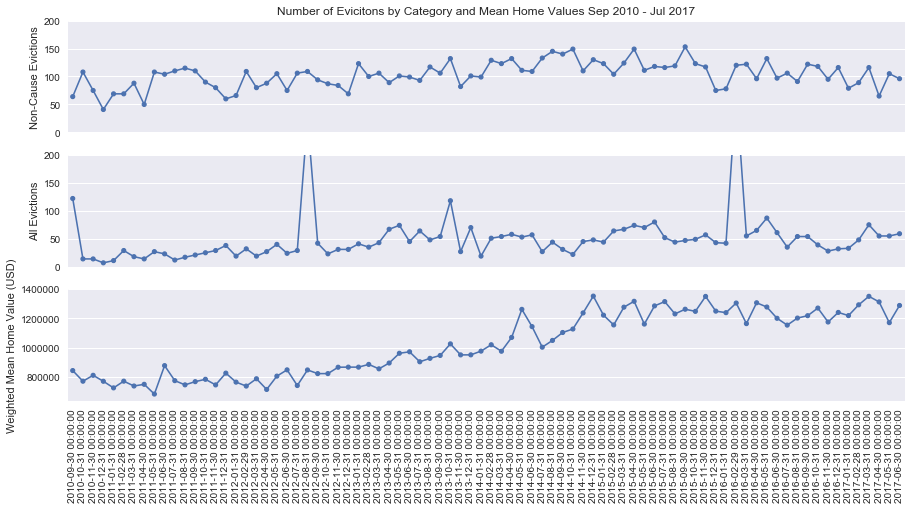

In [60]:
f, axes = plt.subplots(3, 1, figsize=(15, 7), sharex=True, sharey=False)


axes[0] = sns.pointplot(x=groupby_month.index, y=groupby_month['count_cause'], data=groupby_month, scale=0.5, ax=axes[0])
axes[1] = sns.pointplot(x=groupby_month.index, y=groupby_month['count_non_cause'], data=groupby_month, scale=0.5, ax=axes[1])
axes[2] = sns.pointplot(x=groupby_month.index, y=groupby_month['Z_Evict_Date_Value'], data=groupby_month, scale=0.5, ax=axes[2])

axes[0].set_xlabel('')
axes[1].set_xlabel('')
axes[2].set_xlabel('')

axes[0].set_ylabel('Non-Cause Evictions')
axes[1].set_ylabel('All Evictions')
axes[2].set_ylabel('Weighted Mean Home Value (USD)')

axes[0].set_ylim([0, 200])
axes[1].set_ylim([0, 200])

axes[0].set_title('Number of Evicitons by Category and Mean Home Values %s - %s' % (startdate, enddate))
axes[2].set_xticklabels(labels=groupby_month.index, rotation=90)
plt.savefig('Images/evictions_home_values.png')
plt.show()